In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from functools import reduce

In [2]:
trx = pd.read_csv('../data/historical_transactions.csv')
trx['new'] = False
merchants = pd.read_csv('../data/merchants.csv')
new_merchant_trx = pd.read_csv('../data/new_merchant_transactions.csv')
new_merchant_trx['new'] = True
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

Sample the card ID's to trim transaction data down to a unique set of 1000 cards

In [3]:
random.seed(903)
sample = np.random.choice(trx.card_id.unique(), size=1000, replace=False)
trx[trx.card_id.isin(sample)].card_id.unique().size

In [5]:
trx_sample = pd.concat([trx[trx.card_id.isin(sample)], new_merchant_trx[new_merchant_trx.card_id.isin(sample)]])
trx_sample.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,new
198955,Y,C_ID_c47a331073,82,N,0,A,367,M_ID_af44c15ca8,-2,-0.710348,2017-12-23 11:56:34,2.0,23,16,False
198956,Y,C_ID_c47a331073,82,N,0,A,180,M_ID_d4f6b6c852,-11,-0.739395,2017-03-14 12:44:59,2.0,23,20,False
198957,Y,C_ID_c47a331073,82,N,0,A,705,M_ID_ee9b9d1e79,-6,-0.670423,2017-08-14 21:42:19,2.0,23,33,False
198958,Y,C_ID_c47a331073,82,N,0,A,705,M_ID_ec7036fd36,-7,-0.714586,2017-07-14 10:47:56,2.0,23,33,False
198959,Y,C_ID_c47a331073,82,N,0,A,19,M_ID_ad95647d05,-5,-0.732092,2017-09-01 18:20:33,2.0,23,36,False


In [6]:
trx_sample.shape

(101001, 15)

In [7]:
trx_sample.card_id.unique().size

1000

# EDA

Basic look at transactions

In [85]:
trx.describe()

,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.645950e+07,2.911236e+07,2.911236e+07
mean,6.484954e-01,4.810130e+02,-4.487294e+00,3.640090e-02,2.194578e+00,1.056679e+01,2.684839e+01
std,2.795577e+00,2.493757e+02,3.588800e+00,1.123522e+03,1.531896e+00,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [8]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [9]:
trx.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [10]:
print('auth flag: {}\n'
      'unique cards: {}\n'
      'cat_1: {}\n'
      'cat_2: {}\n'
      'cat_3: {}\n'
      'unique merch_cat: {}\n'
      'unique merch_id: {}\n'
      'state_id: {}\n'
      'subsector_id: {}\n'
      .format(
          trx.authorized_flag.unique(),
          len(trx.card_id.unique()),
          trx.category_1.unique(),
          trx.category_2.unique(),
          trx.category_3.unique(),
          len(trx.merchant_category_id.unique()),
          len(trx.merchant_id.unique()),
          len(trx.state_id.unique()),
          len(trx.subsector_id.unique())
      ), sep='\n')

auth flag: ['Y' 'N']
unique cards: 325540
cat_1: ['N' 'Y']
cat_2: [ 1. nan  3.  5.  2.  4.]
cat_3: ['A' 'B' 'C' nan]
unique merch_cat: 327
unique merch_id: 326312
state_id: 25
subsector_id: 41



Some data cleaning/recoding first-steps:
- `authorized_flag` to boolean
- `city_id` to str
- define `city_id` (to put on map)
- `category_1` to boolean
- `category_3` meaning for A, B, C?
- units for `purchase_amount`?
- `category_1` may need to exist as str
- `purchase_date` to datetime

In [11]:
trx.purchase_date = pd.to_datetime(trx.purchase_date)
trx.authorized_flag = trx.authorized_flag.apply(lambda x: True if x == 'Y' else False)
trx.city_id = trx.city_id.apply(str)

In [12]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

Not going to worry about merchants for now. Will first focus on making predictions using only customer data.

First we will need to do some feature engineering for our customers

## Customer level feature engineering

In [36]:
groups = trx.groupby('card_id')
last_day = trx.purchase_date.max()
users = pd.DataFrame()
users['tof'] = (last_day - groups.purchase_date.min()).apply(lambda x: x.days)
users['recency'] = (last_day - groups.purchase_date.max()).apply(lambda x: x.days)
users['frequency'] = groups.size()
users['log_freq'] = users.frequency.apply(np.log)
users['amt'] = groups.purchase_amount.sum()
users['log_amt'] = users['amt'].apply(np.log)
users['avg_amt'] = users['amt'] / users['frequency']
users['log_avg_amt'] = users['avg_amt'].apply(np.log)
users['charge_per_day'] = users['frequency'] / (users['tof'] + 1)
users['log_charge_per_day'] = users['charge_per_day'].apply(np.log)
users['max_amt'] = groups.purchase_amount.max()
users['log_max_amt'] =  users['max_amt'].apply(np.log)
users['n_declines'] = groups.size() - groups.authorized_flag.sum()
users['log_n_declines'] = users['n_declines'].apply(lambda x: np.log(x+1))

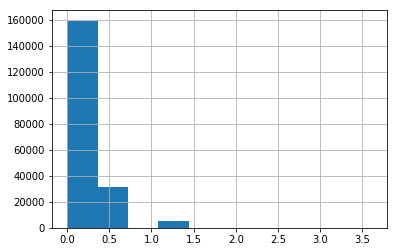

In [10]:
users.log_n_declines.hist()

In [37]:
users.head()

,tof,recency,frequency,log_freq,amt,log_amt,avg_amt,log_avg_amt,charge_per_day,log_charge_per_day,max_amt,log_max_amt,n_declines,log_n_declines
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,379,1,149,5.003946,-76.845041,NaN,-0.515739,NaN,0.392105,-0.936225,1.507069,0.410167,35.0,3.583519
C_ID_0001238066,153,1,123,4.812184,-72.447201,NaN,-0.589002,NaN,0.798701,-0.224768,0.768095,-0.263842,3.0,1.386294
C_ID_0001506ef0,410,11,66,4.189655,-34.601879,NaN,-0.524271,NaN,0.160584,-1.828938,1.493545,0.401153,4.0,1.609438
C_ID_0001793786,403,120,216,5.375278,-36.786013,NaN,-0.170306,NaN,0.534653,-0.626136,4.554145,1.516038,27.0,3.332205
C_ID_000183fdda,205,3,144,4.969813,-68.837938,NaN,-0.478041,NaN,0.699029,-0.358063,2.764788,1.016964,7.0,2.079442


It actually doesn't make sense to take logs on any features based on `purchase_amount` as it has been standardized and thus contains many negative values

In [38]:
full = train.join(users, how='inner', on='card_id')
full.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,tof,recency,frequency,log_freq,amt,log_amt,avg_amt,log_avg_amt,charge_per_day,log_charge_per_day,max_amt,log_max_amt,n_declines,log_n_declines
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,246,3,260,5.560682,-165.968739,NaN,-0.638341,NaN,1.052632,0.051293,2.258395,0.814654,13.0,2.639057
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,418,28,350,5.857933,-210.006336,NaN,-0.600018,NaN,0.835322,-0.179938,4.630299,1.532622,11.0,2.484907
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,413,1,43,3.761200,-29.167391,NaN,-0.678311,NaN,0.103865,-2.264666,-0.145847,NaN,2.0,1.098612
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,155,0,77,4.343805,-49.491364,NaN,-0.642745,NaN,0.493590,-0.706051,1.445596,0.368521,0.0,0.000000
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,108,0,133,4.890349,-48.687656,NaN,-0.366073,NaN,1.220183,0.199001,7.193041,1.973114,5.0,1.791759


In [39]:
test_full = test.join(users, how='left', on='card_id')
test_full.shape

(123623, 19)

In [40]:
# Log/standardize predictors
X = full[['feature_1', 'feature_2', 'feature_3', 'tof', 'recency', 'log_freq',
          'amt', 'avg_amt', 'max_amt', 'log_charge_per_day', 'n_declines']]
Y = full['target']

In [42]:
test_X = test_full[['feature_1', 'feature_2', 'feature_3', 'tof', 'recency', 'log_freq',
          'amt', 'avg_amt', 'max_amt', 'log_charge_per_day', 'n_declines']]
test_X.shape
test_X[test_X.isna().any(axis=1)].size

0

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
len(X_train.dropna())

(151437, 11) (50480, 11) (151437,) (50480,)


151437

## Linear Regression

In [44]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(Y_test, Y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

Coefficients: 
 [-1.86320182e-02  4.37523678e-03  4.15865060e-02 -1.10300490e-03
 -4.71670476e-03  1.96877172e-02 -6.03226695e-04 -1.22295662e-04
  6.13598289e-04 -1.42831955e-01 -1.35873166e-02]
Root Mean squared error: 3.86
Variance score: 0.01


In [45]:
test_preds = regr.predict(test_X)
test_preds.shape

(123623,)

In [78]:
# Format predictions for submission
pd.DataFrame({'card_id':test['card_id'], 'target':test_preds})\
    .to_csv('./submissions.csv', index=False)

In [81]:
# What proportion of the training cards are in new merchant as well
len(set(train.card_id).intersection(set(new_merchant_trx.card_id)))\
    / len(train.card_id.unique())

0.8913860645710862

In [71]:
len(test.card_id.unique())

123623

## Alternate User-Month Analysis

In [18]:
trx_all = pd.concat([trx, new_merchant_trx], axis=0).reset_index()
trx_all.shape

In [24]:
trx_all.columns

Index(['index', 'authorized_flag', 'card_id', 'city_id', 'category_1',
       'installments', 'category_3', 'merchant_category_id', 'merchant_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'category_2',
       'state_id', 'subsector_id', 'new'],
      dtype='object')

In [8]:
trx_sample.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'new'],
      dtype='object')

In [9]:
trx_sample.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,new
131034,Y,C_ID_ca0dbff99d,87,N,1,B,560,M_ID_90aa2e3438,-7,-0.726757,2017-07-18 12:09:50,3.0,11,34,False
131035,Y,C_ID_ca0dbff99d,87,N,1,B,560,M_ID_61985ff3de,-8,-0.697095,2017-06-25 18:12:38,3.0,11,34,False
131036,Y,C_ID_ca0dbff99d,87,N,1,B,307,M_ID_76df359b5e,-1,-0.656749,2018-01-05 20:35:18,3.0,11,19,False
131037,Y,C_ID_ca0dbff99d,87,N,1,B,560,M_ID_3a4ee5348c,-8,-0.678146,2017-06-14 19:24:39,3.0,11,34,False
131038,Y,C_ID_ca0dbff99d,87,N,1,B,80,M_ID_735b2a943d,-8,-0.725119,2017-06-27 15:16:07,3.0,11,37,False


In [6]:
groups = trx_sample.groupby(['card_id', 'month_lag'])

In [35]:
trx_sample.sort_values(['card_id', 'month_lag']).drop_duplicates(['card_id', 'merchant_id'])\
    .groupby(['card_id', 'month_lag']).merchant_id.size().unstack().fillna(0).cumsum(axis=1)

month_lag,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2
card_id,,,,,,,,,,,,,,,,
C_ID_0011762232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,20.0,24.0,33.0,33.0,36.0
C_ID_001da949e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,22.0,36.0,36.0,51.0,59.0,82.0
C_ID_005d18faa1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,9.0,22.0,27.0,31.0,32.0,37.0
C_ID_019ea6c2d1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,5.0,7.0,10.0,10.0
C_ID_01c897183d,6.0,9.0,16.0,21.0,26.0,30.0,35.0,44.0,48.0,54.0,65.0,66.0,66.0,73.0,76.0,76.0
C_ID_02cf37eafc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,7.0,10.0,10.0,10.0,10.0,10.0,10.0
C_ID_02d8c949c0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,6.0,17.0,21.0,26.0,31.0,34.0,35.0,37.0,38.0
C_ID_02f28ab11d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,29.0,36.0,44.0,47.0
C_ID_02fbff949a,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,6.0,6.0,7.0,7.0
